In [1]:
!python -V

Python 3.11.7


In [2]:
# Uncomment to install required packages
#!conda install -c conda-forge -c pytorch u8darts-all ipywidgets psutil gputil tabulate tensorflow -y

In [3]:
import os
import time
import psutil
import GPUtil
import platform
import tabulate
import datetime

from tabulate import tabulate

print("="*120)
print("-"*48, "Uptime Information", "-"*52)
print(f"Last boot:    ", datetime.datetime.fromtimestamp(psutil.boot_time()))
print(f"Current time: ", datetime.datetime.now())
uptimeSeconds = time.time() - psutil.boot_time()
uptime = time.strftime('%dd %Hh %Mm', time.gmtime(uptimeSeconds))
print(f"Current time: ", uptime)
#print(f"Uptime: ", uptime)
print("-"*48, "System Information", "-"*52)
uname = platform.uname()
print(f"System: {uname.system}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")
print("-"*48, "Hardware Information", "-"*50)
print(f"Processor: {uname.processor}")
print("Physical cores:", psutil.cpu_count(logical=False), " - Total cores:", psutil.cpu_count(logical=True))
cpufreq = psutil.cpu_freq()
print(f"Max Frequency: {cpufreq.max:.0f}Mhz", f" - Current Frequency: {cpufreq.current:.0f}Mhz")
svmem = psutil.virtual_memory()
print("Total memory (GB):{:.0f}".format(svmem.total/1e9))
print("-"*48, "GPU Information", "-"*55)
gpus = GPUtil.getGPUs()
list_gpus = []
for gpu in gpus:
    gpu_id = gpu.id
    gpu_name = gpu.name
    gpu_load = f"{gpu.load*100}%"
    gpu_free_memory = f"{gpu.memoryFree}MB"
    gpu_used_memory = f"{gpu.memoryUsed}MB"
    gpu_total_memory = f"{gpu.memoryTotal}MB"
    gpu_temperature = f"{gpu.temperature} °C"
    gpu_uuid = gpu.uuid
    list_gpus.append((
        gpu_id, gpu_name, gpu_load, gpu_free_memory, gpu_used_memory,
        gpu_total_memory
    ))

print(tabulate(list_gpus, headers=("id", "name", "load", "free memory", "used memory", "total memory",
                                   "temperature", "uuid")))
print("="*120)

------------------------------------------------ Uptime Information ----------------------------------------------------
Last boot:     2024-04-10 09:20:16
Current time:  2024-04-10 15:08:45.277925
Current time:  01d 05h 48m
------------------------------------------------ System Information ----------------------------------------------------
System: Darwin
Version: Darwin Kernel Version 23.4.0: Fri Mar 15 00:10:42 PDT 2024; root:xnu-10063.101.17~1/RELEASE_ARM64_T6000
Machine: x86_64
------------------------------------------------ Hardware Information --------------------------------------------------
Processor: i386
Physical cores: 10  - Total cores: 10
Max Frequency: 2400Mhz  - Current Frequency: 2400Mhz
Total memory (GB):17
------------------------------------------------ GPU Information -------------------------------------------------------
id    name    load    free memory    used memory    total memory    temperature    uuid
----  ------  ------  -------------  -------------  

In [4]:
import time
start = time.time()

#Common module parameters:
NUMPY_RANDOM_SEED=10
figsize = (9, 6)

#Train validate test split (70%/15%/15%). Test split is inferred from test and validate values.
train_size = 0.70
valid_size=0.15


LAZY_WALK_LAG=1 # # of periods (hours) to compute metrics for a lazy walk baseline scenario.

MODEL_NAME_RNN='8v5_ALLDNNs-EPOCHS_1000-48-2-BASE_c1'
MODEL_NAME_LSTM='8v5_ALLDNNs-EPOCHS_100-48-2-BASE_c2'
MODEL_NAME_TCN='8v5_ALLDNNs-EPOCHS_100-48-2-BASE_c3'
MODEL_NAME_GRU='8v5_ALLDNNs-EPOCHS_100-48-2-BASE_c4'
MODEL_NAME_NBEATS='8v5_ALLDNNs-EPOCHS_100-48-2-BASE_c5'
MODEL_NAME_TFT='8v5_ALLDNNs-EPOCHS_100-48-2-BASE_c6'

# FOR MACOS "/darts_logs/" OR "\\darts_logs\\" FOR WIN - CHOOSE ACCORDINGLY:
LOG_PATH="/darts_logs/" 
TENSORBOARD_LOG_PATH_RNN = ((os.getcwd() + LOG_PATH + MODEL_NAME_RNN))
TENSORBOARD_LOG_PATH_LSTM = ((os.getcwd() + LOG_PATH + MODEL_NAME_LSTM))
TENSORBOARD_LOG_PATH_TCN = ((os.getcwd() + LOG_PATH + MODEL_NAME_TCN))
TENSORBOARD_LOG_PATH_GRU = ((os.getcwd() + LOG_PATH + MODEL_NAME_GRU))
TENSORBOARD_LOG_PATH_NBEATS = ((os.getcwd() + LOG_PATH + MODEL_NAME_NBEATS))
TENSORBOARD_LOG_PATH_TFT = ((os.getcwd() + LOG_PATH + MODEL_NAME_TFT))

#Deep Neural Network parameters:
#RANDOM_STATE=31
INPUT_CHUNK_LENGTH = 48 #periods = hours
OUTPUT_CHUNK_LENGTH = 1
FORECAST_HORIZON = 1 #periods = hours
HIST_FOR_TIME_START = '2021-10-17T11:00:00' #must be minimum (FORECAST_HORIZON +1) periods ahead of the test start series

N_EPOCHS_RNN=100
N_EPOCHS_LSTM=100
N_EPOCHS_TCN=100
N_EPOCHS_GRU=100
N_EPOCHS_NBEATS=100
N_EPOCHS_TFT=100

In [5]:
import numpy as np
import pandas as pd
import random
from tqdm import tqdm_notebook as tqdm


import matplotlib.pyplot as plt
import torch

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel, RNNModel, TCNModel, BlockRNNModel, NBEATSModel, ARIMA, Prophet
from darts.metrics import mape, rmse, r2_score, mae, mse

import warnings
warnings.filterwarnings("ignore")

import logging
logging.disable(logging.CRITICAL)

%matplotlib inline

/opt/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [6]:
#DARTS version 0.17.1
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

psutil==5.9.8
GPUtil==1.4.0
platform==1.0.8
numpy==1.26.4
pandas==2.1.4
torch==2.1.0.post100
logging==0.5.1.2


In [7]:
df = pd.read_csv(r"/Users/elopes/Book3.csv", delimiter=";", parse_dates=["timestamp"])
#df = pd.read_csv(r"C:\Users\User\Downloads\price-ohlc-eth-1h-final.csv", parse_dates=["timestamp"])
df['timestamp'] = pd.to_datetime(df.timestamp).dt.tz_localize(None)
nof_missing_values_o = sum(np.isnan(df['o']))
nof_missing_values_h = sum(np.isnan(df['h']))
nof_missing_values_l = sum(np.isnan(df['l']))
nof_missing_values_c = sum(np.isnan(df['c']))

df = df.fillna(method="backfill")
nof_missing_values = sum(np.isnan(df['o']))

df = df.fillna(method="backfill")
nof_missing_values = sum(np.isnan(df['h']))

df = df.fillna(method="backfill")
nof_missing_values = sum(np.isnan(df['l']))

df = df.fillna(method="backfill")
nof_missing_values = sum(np.isnan(df['c']))

train_index = int(len(df)*train_size)

df_train = df[0:train_index]
df_rem = df[train_index:]

valid_index = int(len(df)*valid_size)

df_val = df[train_index:train_index+valid_index]
df_test = df[train_index+valid_index:]

series = TimeSeries.from_dataframe(df, time_col='timestamp', value_cols=['c']).astype(np.float32)
series_covariates = TimeSeries.from_dataframe(df, time_col='timestamp', value_cols=['h','l','o']).astype(np.float32)
train = TimeSeries.from_dataframe(df_train, time_col='timestamp', value_cols=['c']).astype(np.float32)
train_covariates = TimeSeries.from_dataframe(df_train, time_col='timestamp', value_cols=['h','l','o']).astype(np.float32)
val = TimeSeries.from_dataframe(df_val, time_col='timestamp', value_cols=['c']).astype(np.float32)
val_covariates = TimeSeries.from_dataframe(df_val, time_col='timestamp', value_cols=['h','l','o']).astype(np.float32)
test = TimeSeries.from_dataframe(df_test, time_col='timestamp', value_cols=['c']).astype(np.float32)
test_covariates = TimeSeries.from_dataframe(df_test, time_col='timestamp', value_cols=['h','l','o']).astype(np.float32)

In [8]:
from sklearn.preprocessing import (
    MaxAbsScaler,
#    MinMaxScaler, (valor default utilizado pelo wrapper Darts)
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
)

transformer = Scaler(StandardScaler())
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
test_transformed = transformer.transform(test)
train_covariates_transformed = transformer.fit_transform(train_covariates)
val_covariates_transformed = transformer.transform(val_covariates)
test_covariates_transformed = transformer.transform(test_covariates)

In [9]:
train_transformed.head()

<TimeSeries (DataArray) (timestamp: 5, component: 1, sample: 1)>
array([[[-0.8011138 ]],

       [[-0.7999836 ]],

       [[-0.79951876]],

       [[-0.8000019 ]],

       [[-0.79995185]]], dtype=float32)
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 2020-01-01 ... 2020-01-01T04:00:00
  * component  (component) object 'c'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Text(0.5, 1.0, 'Conjunto de Dados Ethereum - Treinamento, Validacao e Teste')

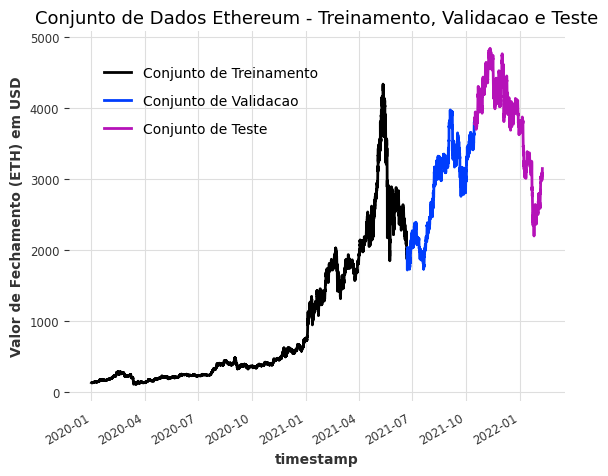

In [10]:
train.plot(label="Conjunto de Treinamento")
val.plot(label="Conjunto de Validacao")
test.plot(label="Conjunto de Teste")
plt.legend(
           borderpad=2,
           labelspacing=1.0,
           title_fontsize='large',
           shadow=False,
           frameon=False,
           loc='best'  
          )
plt.ylabel('Valor de Fechamento (ETH) em USD')
plt.title('Conjunto de Dados Ethereum - Treinamento, Validacao e Teste',fontsize=13)

In [11]:
print("="*72)
print('Dataset type',' -      Start time    -', '     End time','    -Samples', '- %split')
print("-"*72)
print('Full dataset: ', series.start_time(),'', series.end_time(),'', len(series),'     {:.0f}'.format((len(series)/len(series)*100)))
print('Train set:    ', train.start_time(),'', train.end_time(),'', len(train),'      {:.0f}'.format((len(train)/len(series)*100)))
print('Validate set: ', val.start_time(),'', val.end_time(),' ', len(val),'      {:.0f}'.format((len(val)/len(series)*100)))
print('Test set:     ', test.start_time(),'', test.end_time(),' ', len(test),'      {:.0f}'.format((len(test)/len(series)*100)))
print("="*72)

Dataset type  -      Start time    -      End time     -Samples - %split
------------------------------------------------------------------------
Full dataset:  2020-01-01 00:00:00  2022-02-07 18:00:00  18451      100
Train set:     2020-01-01 00:00:00  2021-06-22 02:00:00  12915       70
Validate set:  2021-06-22 03:00:00  2021-10-15 09:00:00   2767       15
Test set:      2021-10-15 10:00:00  2022-02-07 18:00:00   2769       15


In [12]:
tic_prep = time.time()
prep_elapsed_time = tic_prep - start
print(prep_elapsed_time,'seconds')

28.78178596496582 seconds


In [13]:
for i in range (11,32,1):
    tic_ann_begin = time.time()

    
    tcn_model = TCNModel(
    input_chunk_length=INPUT_CHUNK_LENGTH,
    output_chunk_length=FORECAST_HORIZON,
    kernel_size=5,
    num_filters=3,
    weight_norm=True,
    dilation_base=2,
    num_layers=1,
    dropout=0.1,
    loss_fn=torch.nn.MSELoss(),
    optimizer_cls=torch.optim.Adam,
    optimizer_kwargs={"lr": 1e-3},
    batch_size=16,    
    n_epochs=N_EPOCHS_TCN,
    model_name=MODEL_NAME_TCN,
    log_tensorboard=True,
    pl_trainer_kwargs={
 #        'accelerator': 'gpu', 'gpus': [0],
 #         'progress_bar_refresh_rate': False,
          'enable_model_summary': False,
       },
    force_reset=True,
    save_checkpoints=True,
    random_state=i,
    )

    tcn_model.fit(
        series=train_transformed,
        val_series=val_transformed,
        past_covariates=series_covariates,
        val_past_covariates=val_covariates,
        verbose=False,
    )
    
    
    best_tcn_model = TCNModel.load_from_checkpoint(model_name=MODEL_NAME_TCN, best=True)
    
    tic_ann_end = time.time()
    ann_elapsed_time = tic_ann_end - tic_ann_begin
    
    backtest_series_tcn = best_tcn_model.historical_forecasts(
    series=test_transformed,
    start=pd.Timestamp(HIST_FOR_TIME_START),            
    forecast_horizon=FORECAST_HORIZON,
    stride=1,
    retrain=False,
    verbose=False,
    )

    tic_ann_backtest_end = time.time()
    ann_backtest_elapsed_time= tic_ann_backtest_end - tic_ann_end

    print(
      "{:.0f};".format(i),
      "{:.8f}".format(mse(backtest_series_tcn, test_transformed)),
      "{:.8f};".format(mae(backtest_series_tcn, test_transformed)),
      "{:.8f};".format(rmse(backtest_series_tcn, test_transformed)),
      "{:.8f};".format(r2_score(backtest_series_tcn, test_transformed)),
#      "{:.8f};".format(mape(backtest_series_tcn, test_transformed)),
      "{:.8f}".format(ann_elapsed_time),
      "{:.8f}".format(ann_backtest_elapsed_time)
    )
    
    arquivo = open('PEL309-8v6_ETH-EPOCHS_100-48-1-16-TCN-StandardScaler.txt', 'a')
    print("{:.0f};".format(i),
    "{:.8f};".format(mse(backtest_series_tcn, test_transformed)),
    "{:.8f};".format(mae(backtest_series_tcn, test_transformed)),
    "{:.8f};".format(rmse(backtest_series_tcn, test_transformed)),
    "{:.8f};".format(r2_score(backtest_series_tcn, test_transformed)),
#    "{:.8f};".format(mape(backtest_series_tcn, test_transformed)),
    "{:.8f}".format(ann_elapsed_time),
    "{:.8f}".format(ann_backtest_elapsed_time), file=arquivo) 
    arquivo.close()

2024-04-10 15:09:16.051599: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


11; 0.17004606 0.29393879; 0.41236642; 0.74641168; 373.12200308 1.73033500
12; 0.00114213 0.02350533; 0.03379548; 0.99771061; 357.14385200 2.11188006
13; 0.00120479 0.02420028; 0.03471002; 0.99758302; 355.04326916 1.74196482
14; 0.00118857 0.02403398; 0.03447568; 0.99761343; 357.86800098 2.12108898
15; 0.01279582 0.08227854; 0.11311860; 0.97461781; 362.96752620 2.08112693
16; 0.00107980 0.02277119; 0.03286028; 0.99783069; 356.94543624 1.84000683
17; 0.00109421 0.02289872; 0.03307888; 0.99780525; 365.99144006 2.16292095
18; 0.00130341 0.02523974; 0.03610272; 0.99738391; 353.52402711 1.71233106
19; 0.04015153 0.15292320; 0.20037846; 0.92224992; 353.62812185 2.31410933
20; 0.08273613 0.22879761; 0.28763887; 0.84006174; 366.08929205 2.14927793
21; 0.00110076 0.02303683; 0.03317777; 0.99779225; 368.93762088 2.56839609
22; 0.00663611 0.05934929; 0.08146232; 0.98704726; 360.34851098 1.73115706
23; 0.00107659 0.02321471; 0.03281151; 0.99784163; 364.80366182 2.22579098
24; 0.00134560 0.02611320